# Classifying Cats Vs Dogs With 96% Accuracy 

### Introduction

The classification of cats and dogs has been a long standing deep learning challenge facilitated by Kaggle. This notebook explores the use of Convolutional Neural Networks (CNNs), data augmentation, and other regularization techniques as they relate to this binary classification problem. This is achieved without the use of transfer learning or pretrained models.

### Data Preparation

Data preparation is the foundation of any machine learning model. In this section, we delve into the systematic approach of preparing, augmenting, and loading data, ensuring our model is trained and tested effectively to mitigate overfitting and enhance generalization.

Initially, we import necessary libraries and set up parameters and classes to manage our dataset. Our dataset is sourced from Kaggle and can be downloaded here (https://www.kaggle.com/c/dogs-vs-cats/data). This is a balanced dataset that comprises 12500 cats and 12500 dogs. We employ a CatsDogsDataset class to handle these images and their labels. This class, utilizing PyTorch's Dataset library, enables efficient data handling and transformations.

We then define a Dogvscat class, which performs the core of our data preparation. It reads the images, converts them to grayscale for uniformity, and resizes them to a consistent dimension. Importantly, we randomly shuffle the data and split it into training and testing sets, ensuring a robust evaluation of our model's performance on unseen data.

To address the critical challenge of overfitting, we implement data augmentation within the Dogvscat class. This process artificially expands the diversity of our training dataset by applying random, realistic transformations to the images, such as rotation, color jitter, and flips. This enhancement makes our model more resilient and better at generalizing from its training data.

Once our data is augmented and split, we utilize PyTorch's DataLoader to efficiently batch and load the data during training and testing. This approach significantly improves memory usage and computational efficiency, crucial for handling large datasets and complex models.

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda:0") # Use GPU
BATCH_SIZE = 400
EPOCHS = 150
IMG_SIZE_GLOBAL = 150

In [2]:
class CatsDogsDataset(Dataset):
    def __init__(self, data, transform=None):
        # Constructor method initializing the data and any transformations to be applied.
        self.data = data
        self.transform = transform

    def __len__(self):
        # Returns the total number of samples in the dataset.
        return len(self.data)

    def __getitem__(self, idx):
        # Retrieves an image and its label by index and applies transformations if any.
        img, label = self.data[idx]
        img = Image.fromarray(img)  # Convert numpy array back to image.

        if self.transform:
            img = self.transform(img) # Apply the transformations to the image.
        
        
        # Convert the image back to a tensor and return with its corresponding label.
        return transforms.ToTensor()(img), torch.Tensor(label)

# Data augmentation transformations.
augmentation_transforms = transforms.Compose([
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 10% random horizontal and vertical shifts.
    transforms.RandomHorizontalFlip(),  # Random horizontal flips.
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.RandomRotation(degrees=10)
])

# Main class for preparing the Cats vs. Dogs dataset.
class Dogvscat():
    IMG_SIZE = IMG_SIZE_GLOBAL
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1} # Label encoding for cats and dogs.
    training_data = []  # List to store training data.
    testing_data = []  # List to store testing data.
    catcount = 0  # Counter for the number of cat images.
    dogcount = 0  # Counter for the number of dog images.
    
    def make_training_data(self):
        # Process images, split into training and testing sets, and apply data augmentation.
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f) # Create the full image path.
                    img = Image.open(path).convert('L')  # Open and convert the image to grayscale.
                    img = img.resize((self.IMG_SIZE, self.IMG_SIZE)) # Resize the image to IMG_SIZE.
                    
                    # Append the image and its label to the training_data list.
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])
                    
                    # Increment the cat or dog counter depending on the label.
                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
                    #handle errors
                    #print(str(e)) 
                    pass
        
        # Randomly shuffle the training data.
        np.random.shuffle(self.training_data)
        
        # Splitting the data into 90% training and 10% testing.
        train_size = int(0.9 * len(self.training_data))
        self.testing_data = self.training_data[train_size:]
        self.training_data = self.training_data[:train_size]

        # Saving training and testing data separately
        with open("training_data.pkl", "wb") as f:
            pickle.dump(self.training_data, f)
        with open("testing_data.pkl", "wb") as f:
            pickle.dump(self.testing_data, f)
        
         # Initialize DataLoader for training and testing data for efficient batch processing during model training.
        self.train_loader = DataLoader(CatsDogsDataset(self.training_data, transform=augmentation_transforms), batch_size=BATCH_SIZE, shuffle=True)
        self.test_loader = DataLoader(CatsDogsDataset(self.testing_data), batch_size=BATCH_SIZE, shuffle=False)

        # Print out the count of cat and dog images processed.
        print("Cats: ", self.catcount)
        print("Dogs: ", self.dogcount)

In [3]:
# Create Data.
dogvcat = Dogvscat()
dogvcat.make_training_data()
print("Data preparation complete.")

PetImages/Cat


100%|███████████████████████████████████████████████████████████████████████████| 12501/12501 [00:22<00:00, 566.89it/s]


PetImages/Dog


 91%|████████████████████████████████████████████████████████████████████▎      | 11396/12501 [00:20<00:02, 538.43it/s]C:\ProgramData\anaconda3\Lib\site-packages\PIL\TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|███████████████████████████████████████████████████████████████████████████| 12501/12501 [00:22<00:00, 549.52it/s]


Cats:  12499
Dogs:  12499
Data preparation complete.


In [4]:
# Define data loaders with the appropriate transformations.

train_loader = DataLoader(CatsDogsDataset(dogvcat.training_data, transform=augmentation_transforms), batch_size=BATCH_SIZE, shuffle=True)

test_loader = DataLoader(CatsDogsDataset(dogvcat.testing_data), batch_size=BATCH_SIZE, shuffle=False)

### Model Archetecture

Our classification model is built on a Convolutional Neural Network (CNN), a deep learning architecture well-suited for analyzing visual imagery. CNNs excel in capturing spatial hierarchies in data by applying convolutional layers that filter inputs to produce feature maps. These maps highlight various aspects of the input data, such as edges and textures, which are crucial for image classification tasks.

The network features four convolutional layers, each followed by a dropout layer to mitigate overfitting by randomly nullifying portions of the feature maps. This promotes the learning of more robust and generalizable features. After the convolutional and dropout stages, a 2x2 max pooling operation is applied, effectively reducing the spatial dimensions by half and enhancing the network's ability to extract dominant features while also improving computational efficiency.

Sequentially, the model transitions from convolutional layers to a fully connected architecture. The output from the final pooling layer is flattened into a one-dimensional vector and then projected into a 512-dimensional space by the first dense layer. This process amalgamates the learned features across all preceding layers into a form suitable for classification.

The final layer of the model is a fully connected layer that outputs a scalar value reflecting the model's confidence in the presence of the target class—in this case, distinguishing between images of dogs and cats.

This scalar is then processed through a sigmoid activation function, scaling the output to a probability range between 0 and 1. The Binary Cross-Entropy Loss (BCELoss) function is employed as our loss function, chosen for its effectiveness in comparing the predicted probability with actual binary labels and penalizing incorrect predictions more severely.

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        self.conv4 = nn.Conv2d(128, 256, 5)
        
        # Testing dropout layers.
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.2)
        self.dropout4 = nn.Dropout(0.5)
        
        # get the size after the conv layers.
        x = torch.randn(IMG_SIZE_GLOBAL, IMG_SIZE_GLOBAL).view(-1, 1, IMG_SIZE_GLOBAL, IMG_SIZE_GLOBAL)

        out = self.convs(x)
        flattened_size = out.shape[1] * out.shape[2] * out.shape[3]  
        
        self.fc1 = nn.Linear(flattened_size, 512)
        self.fc2 = nn.Linear(512, 1) # output
        self.flatten = nn.Flatten()

    def convs(self, x):
        x = self.dropout1(F.max_pool2d(F.relu(self.conv1(x)), (2, 2)))
        x = self.dropout2(F.max_pool2d(F.relu(self.conv2(x)), (2, 2)))
        x = self.dropout3(F.max_pool2d(F.relu(self.conv3(x)), (2, 2))) 
        x = self.dropout4(F.max_pool2d(F.relu(self.conv4(x)), (2, 2)))
        return x
    
        
    def forward(self, x):
        x = self.convs(x) # Pass through conv layers
        x = self.flatten(x) # Flatten the tensor
        x = self.dropout4(F.relu(self.fc1(x))) # Pass through first fully connected layer
        x = self.fc2(x) # Pass through final layer
        return torch.sigmoid(x) # Apply sigmoid for BCELoss

net = Net().to(device)

### Training 

Our Convolutional Neural Network (CNN) now undergoes training through iterative epochs, each involving a forward propagation of data and subsequent parameter updates via backpropagation. The model's performance is periodically evaluated against a validation set through a separate testing function, providing loss and accuracy metrics.

Each epoch represents a complete cycle of learning, with the model adjusting its weights to minimize the discrepancy between predicted and actual outcomes. Performance metrics are logged systematically to monitor and ensure convergence. From testing between various training runs our model performs quite well at around 50 epochs but I was able to yield tangible improvements by extending the training runs first to 100 and then to 150. 

In [6]:
def fwd_pass(x, y, train=False):
    # If training, reset gradients of the model parameters.
    if train:
        net.zero_grad()
    
    # Feed the input batch through the network to obtain outputs.
    outputs = net(x)
    
    # Calculate the loss between network outputs and true labels.
    loss = loss_function(outputs, y.unsqueeze(1))  

    # Compare output probability with threshold 0.5
    predicted_classes = outputs > 0.5
    
    # Calculate the number of correct predictions by comparing to true labels.
    correct = (predicted_classes.flatten() == y).float()  # Flatten to match dimensions with y
    acc = correct.sum() / len(correct)

    # If training, perform backpropagation and optimization.
    if train:
        loss.backward()
        optimizer.step()
    return acc, loss

In [7]:
def test(size=32):
    # Set the model to evaluation mode
    net.eval()
    if size > len(test_loader.dataset):
        print(f"Requested size {size} is too large for the available test data. Adjusting to {len(test_loader.dataset)}.")
        size = len(test_loader.dataset)

    test_acc = 0
    test_loss = 0
    
    # No gradient tracking needed for evaluation.
    with torch.no_grad():
        for batch_x, batch_y in test_loader:  
            # Move the input batch and labels to the appropriate device.
            batch_x = batch_x.view(-1, 1, IMG_SIZE_GLOBAL, IMG_SIZE_GLOBAL).to(device)
            batch_y = batch_y[:,1].to(device)  
            
            # Perform forward pass and accumulate the accuracy and loss.
            acc, loss = fwd_pass(batch_x, batch_y)
            test_acc += acc.item()
            test_loss += loss.item()
    
    # Calculate average accuracy and loss over the test set.
    val_acc = test_acc / len(test_loader)
    val_loss = test_loss / len(test_loader)

    return val_acc, val_loss


In [8]:
# Model, optimizer, and loss function setup.
MODEL_NAME = f"model-{int(time.time())}"
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.BCELoss() 
print(MODEL_NAME)

# Training loop: Iterates over epochs, performs training and validation.
def train():
    train_losses = []
    val_losses = [] 
    train_accuracies = []
    val_accuracies = []
    
    with open("model.log", "a") as f:
        for epoch in range(EPOCHS):
            net.train()  # Training mode
            total_train_loss = 0
            total_train_acc = 0
            batch_count = 0
            
            for batch_x, batch_y in tqdm(train_loader): 
                # Preprocess and move the input batch and labels to the appropriate device.
                batch_x = batch_x.view(-1, 1, IMG_SIZE_GLOBAL, IMG_SIZE_GLOBAL).to(device)
                batch_y = batch_y[:,1].to(device)  
                
                # Perform forward pass
                acc, loss = fwd_pass(batch_x, batch_y, train=True)
                total_train_loss += loss.item()
                total_train_acc += acc.item()
                batch_count += 1
            
            # Calculate and store average loss and accuracy for the epoch.
            epoch_loss = total_train_loss / batch_count
            epoch_acc = total_train_acc / batch_count
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc)
            
            # Perform validation at the end of each epoch and store metrics.
            val_acc, val_loss = test(size=len(test_loader.dataset))  # Validate on the entire test set
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            
            # Print loss and accuracy for live monitoring 
            print(val_loss)
            print(val_acc)
            f.write(f"{MODEL_NAME}, Epoch: {epoch}, Train Loss: {round(epoch_loss,4)}, Train Acc: {round(epoch_acc,2)}, Val Loss: {round(val_loss,4)}, Val Acc: {round(val_acc,2)}\n")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Begin Training
train_losses, val_losses, train_accuracies, val_accuracies = train()

model-1704436332


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:36<00:00,  1.58it/s]


0.6862084524972099
0.5314285499708993


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.6620032617024013
0.6003571408135551


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.6386619125093732
0.6307142632348197


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.6355620537485395
0.6332142693655831


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.5741835577147347
0.7153571248054504


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.5484974341733115
0.706428553376879


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.63it/s]


0.47922103319849285
0.7799999799047198


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.4565731542451041
0.7849999836512974


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.3979074146066393
0.8207142693655831


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.424616630588259
0.8124999744551522


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.3453301659652165
0.84178569487163


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.35889476111957
0.832499989441463


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.32949118529047283
0.8574999741145543


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.2942057379654476
0.8610714163099017


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.28076454997062683
0.8760714190346854


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.3124330682413919
0.8571428315980094


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.63it/s]


0.24866729548999242
0.8864285605294364


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.2398493311234883
0.893928553376879


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.24443045684269496
0.8921428322792053


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.29923988027232035
0.8660714115415301


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.2205470140491213
0.9049999713897705


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.21725034075123922
0.9117856792041233


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.3169165125914982
0.8624999863760812


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.20799754134246282
0.9071428264890399


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.22100155907017843
0.9067857010023934


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.63it/s]


0.20805938754762923
0.9053571139063153


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.19117981408323562
0.9178571105003357


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.18190454585211618
0.9296428390911647


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.19133060106209346
0.9178571105003357


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.17640305629798345
0.9267856904438564


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.17690024844237737
0.9253571288926261


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.20082320698669978
0.9146428278514317


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.16468480016504014
0.9264285479273114


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.16995014250278473
0.9299999816077096


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.1763234862259456
0.9235713992800031


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.16237347253731318
0.9332142642566136


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.17399196113858903
0.9303571156093052


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.1679696078811373
0.9307142581258502


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.18640229531696864
0.9224999717303685


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.24960915531430924
0.8910714132445199


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.18683128484657832
0.9196428230830601


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.1723994037934712
0.928214260510036


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.63it/s]


0.19498789949076517
0.9153571128845215


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.1487385481595993
0.9396428465843201


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.17020795813628606
0.9303571241242545


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.15488914506775991
0.9353571363857814


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.15044939730848586
0.9346428428377423


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.15016320134912217
0.940714282648904


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.17447988050324575
0.9264285394123623


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.1522193221109254
0.9335714152881077


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.15857969437326705
0.9332142727715629


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.13999204550470626
0.9382142765181405


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.14218268437044962
0.9439285567828587


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.14945651590824127
0.9364285554204669


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.1479455413562911
0.9396428380693708


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.13873858004808426
0.9460714203970773


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.14027945271560124
0.9392857125827244


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.1548211702278682
0.9342856918062482


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.17013075947761536
0.931785694190434


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.1466058279786791
0.9399999891008649


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.13244993558951787
0.9442857078143528


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.13749862888029643
0.9428571377481733


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.14153720970664704
0.9382142765181405


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.14538721846682684
0.9389285700661796


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.1410482366170202
0.9424999952316284


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.15050373652151652
0.9353571278708321


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.1488840260675975
0.9382142765181405


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.13915383922202246
0.9396428465843201


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.16742900546107972
0.9296428390911647


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.13338561249630793
0.9453571353639875


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.1462635642715863
0.9360714129039219


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.1433631948062352
0.9414285591670445


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.13459180827651704
0.9382142765181405


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.13459009251424245
0.9449999928474426


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.13406223271574294
0.9460714203970773


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.1348039231130055
0.9464285629136222


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.13664640273366654
0.9417857016835894


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.1607100729431425
0.9321428452219281


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.1388254165649414
0.9446428418159485


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.15453661658934184
0.9353571363857814


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.15350026105131423
0.9374999914850507


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.13322113241468156
0.9424999867166791


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.1299538974251066
0.946785705430167


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.14317388939005987
0.9410714251654488


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.1462184957095555
0.9392857125827244


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.13110827122415816
0.9464285629136222


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.14138815658433096
0.9417857016835894


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.13126261745180404
0.9503571305956159


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.12342420646122523
0.946785705430167


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.14947761914559773
0.9389285530362811


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.1256619734423501
0.9524999856948853


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.1594933196902275
0.9364285554204669


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.13194875419139862
0.9457142778805324


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.14935619490487234
0.9360714129039219


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.1403945130961282
0.9421428527150836


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.12277165481022426
0.9460714203970773


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.13178602712494986
0.946785705430167


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.12688173672982625
0.9453571353639875


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.12184142853532519
0.9496428455625262


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.16059567672865732
0.9346428428377423


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.12612958678177424
0.9474999904632568


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.14549991488456726
0.9392857040677752


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.1742063249860491
0.9228571142469134


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.12349952012300491
0.9524999856948853


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.14274083822965622
0.943928565297808


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.12158171300377164
0.9521428431783404


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.14496278443506785
0.9449999928474426


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.11707454068320138
0.9560714108603341


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.127879193850926
0.9517857006617955


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.14395771707807267
0.9410714166504996


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.14423769073826925
0.9464285629136222


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.12289091093199593
0.9524999856948853


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.12250929645129613
0.9510714156287057


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.13565422700984137
0.9446428503308978


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.1265363810317857
0.9485714180128915


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.1502658873796463
0.9378571254866463


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.11920652432101113
0.9571428384099688


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.1270626378910882
0.9528571282114301


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.1272325004850115
0.949999988079071


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.13137753627129964
0.9517857006617955


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.12331892549991608
0.9521428431783404


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.1349899364369256
0.9464285629136222


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.12430644886834281
0.9503571305956159


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.14207747365747178
0.9460714203970773


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.12206163789544787
0.9528571282114301


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.13789191203457968
0.9478571329798017


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.11916342377662659
0.9517857006617955


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.15381291934422084
0.9385714105197361


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.1277180878179414
0.9496428455625262


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.12791112597499574
0.953214270727975


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.11868599908692497
0.9528571282114301


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.1347391339285033
0.9464285543986729


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.14688079910618917
0.9428571292332241


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.1197791684951101
0.9528571282114301


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.12121525193963732
0.9549999833106995


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.13253509679010936
0.9521428431783404


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.11766576660530907
0.9521428431783404


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.11803072478090014
0.9553571258272443


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.12893403534378325
0.9517857006617955


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.15664385578462056
0.9453571353639875


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.12268602102994919
0.9542856982776097


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.13143607335431234
0.9517857006617955


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.11736895143985748
0.949999988079071


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.12745203290666854
0.9492857030459813


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.12452813344342369
0.9517857006617955


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.14225232601165771
0.943928565297808


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.11948326336486
0.9521428431783404


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.1327126239027296
0.9510714156287057


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.65it/s]


0.12285205296107701
0.9514285581452506


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:34<00:00,  1.64it/s]


0.11704663187265396
0.9567856958934239


### Evaluation

Upon completing the training, our model demonstrates robust performance with an accuracy of 96%, complemented by an F1-Measure of 0.96. The precision and recall are closely matched at 0.96 and 0.95, respectively, indicating a balanced treatment of classes. A near-perfect ROC AUC of 0.99 suggests excellent class separation, and a low Brier Score of 0.03, coupled with a Brier Skill Score of 0.87, confirms the model's predictive reliability.

Signs of overfitting emerge around epoch 150, suggesting that further training is unlikely to yield improvement. Future efforts may focus on expanding the dataset or exploring more advanced regularization techniques.

In [9]:
from sklearn.metrics import roc_auc_score, brier_score_loss, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc
import warnings
warnings.simplefilter("ignore", category=FutureWarning)

def plot_roc_curve(labels, predictions):
    fpr, tpr, thresholds = roc_curve(labels, predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 8))
    lw = 2  # Line width
    sns.set(style="whitegrid")
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    sns.despine(offset=10, trim=True)  
    plt.show()



def plot_brier_score(labels, predictions):
    brier_score_value = brier_score_loss(labels, predictions)

    plt.figure(figsize=(10, 8))
    sns.set(style="whitegrid")
    sns.histplot(predictions, kde=True, color="darkorange", linewidth=2, edgecolor='w')
    plt.title(f'Brier Score Distribution (Score: {brier_score_value:.2f})', fontsize=16)
    plt.xlabel('Predicted Probabilities', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    sns.despine(offset=10, trim=True)  
    plt.show()


In [23]:
def test_final(net):
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for batch_x, batch_y in tqdm(test_loader):
            batch_x = batch_x.to(device)
            batch_y = batch_y[:, 1].to(device)
            
            net_out = net(batch_x).squeeze()
            predictions = net_out.cpu().numpy()
            labels = batch_y.cpu().numpy()
            
            all_labels.extend(labels)
            all_predictions.extend(predictions)

    # Convert predictions and labels to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    
    # Convert probabilities to binary predictions
    predicted_classes = (all_predictions > 0.5).astype(int)
    
    # Calculate metrics
    roc_auc = roc_auc_score(all_labels, all_predictions)
    brier_score = brier_score_loss(all_labels, all_predictions)
    f1 = f1_score(all_labels, predicted_classes)
    precision = precision_score(all_labels, predicted_classes)
    recall = recall_score(all_labels, predicted_classes)

    # Calculate Brier Skill Score
    bs_ref = np.mean(all_labels) * (1 - np.mean(all_labels))
    brier_skill_score = 1 - (brier_score / bs_ref)

    # Calculate and display the confusion matrix
    cm = confusion_matrix(all_labels, predicted_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label (1 = Dog | 0 = Cat)')
    plt.xlabel('Predicted Label')
    plt.show()

    # Print all metrics
    print("ROC AUC: ", round(roc_auc, 2))
    print("Brier Score: ", round(brier_score, 2))
    print("Brier Skill Score: ", round(brier_skill_score, 2))
    print("F1-Measure: ", round(f1, 2))
    accuracy = (cm[0][0] + cm[1][1]) / np.sum(cm)
    print("Accuracy: ", round(accuracy, 2))
    print("Precision: ", round(precision, 2))
    print("Recall: ", round(recall, 2))
    # Assuming these functions exist and are defined elsewhere
    plot_roc_curve(all_labels, all_predictions)  
    plot_brier_score(all_labels, all_predictions)  


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.29it/s]


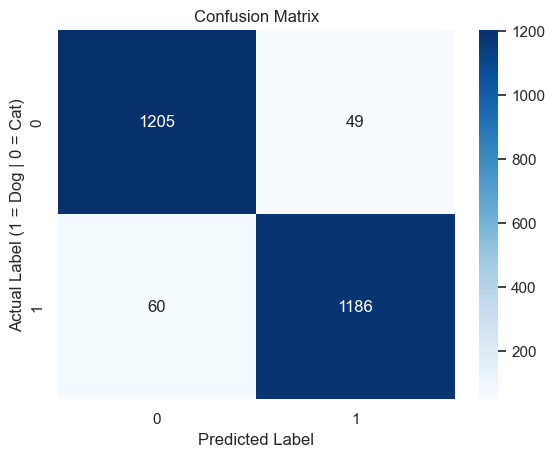

ROC AUC:  0.99
Brier Score:  0.03
Brier Skill Score:  0.87
F1-Measure:  0.96
Accuracy:  0.96
Precision:  0.96
Recall:  0.95


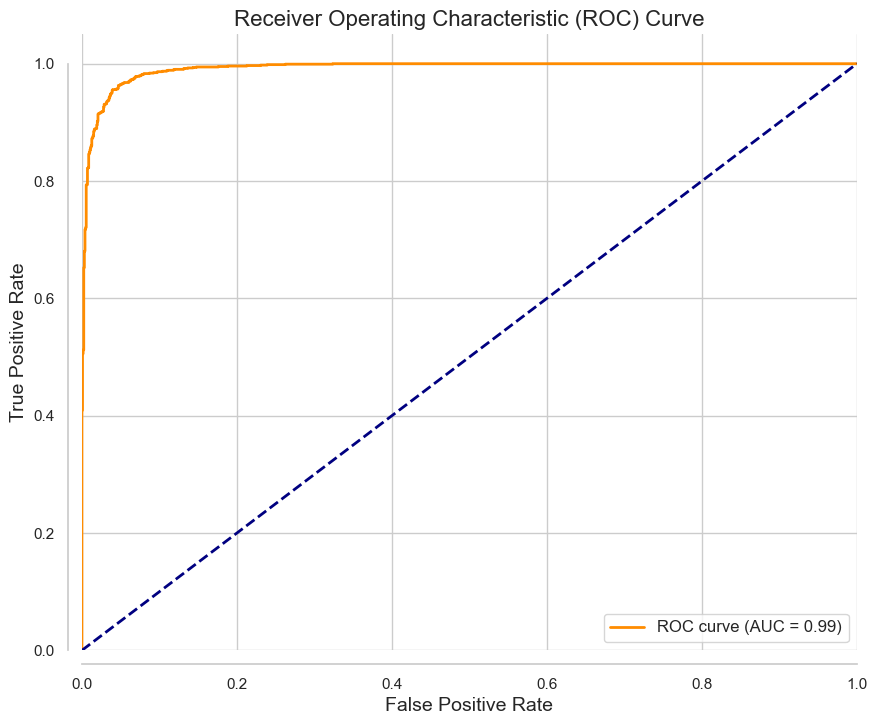

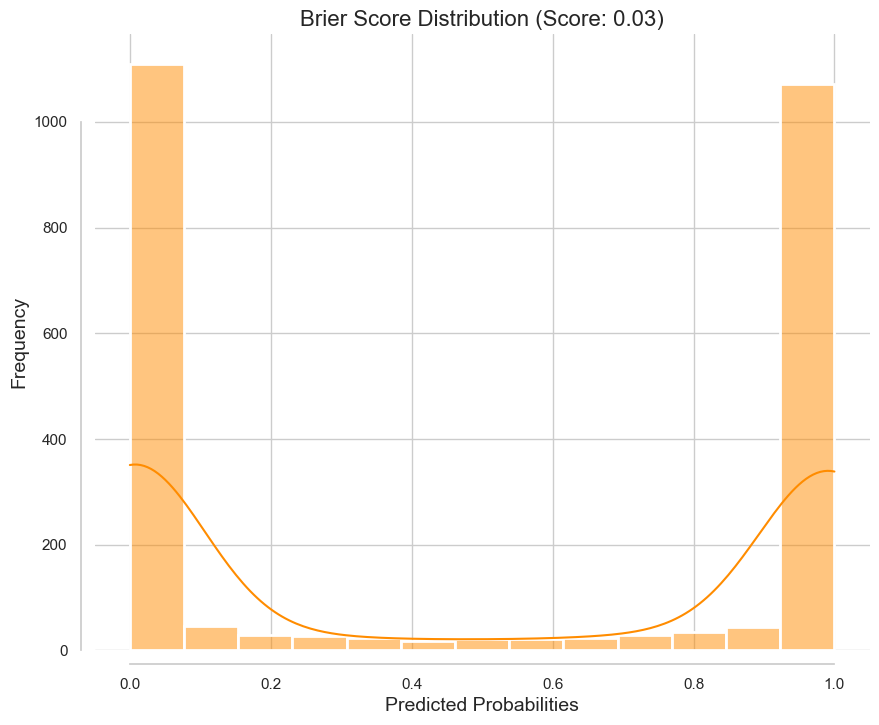

In [24]:
test_final(net)

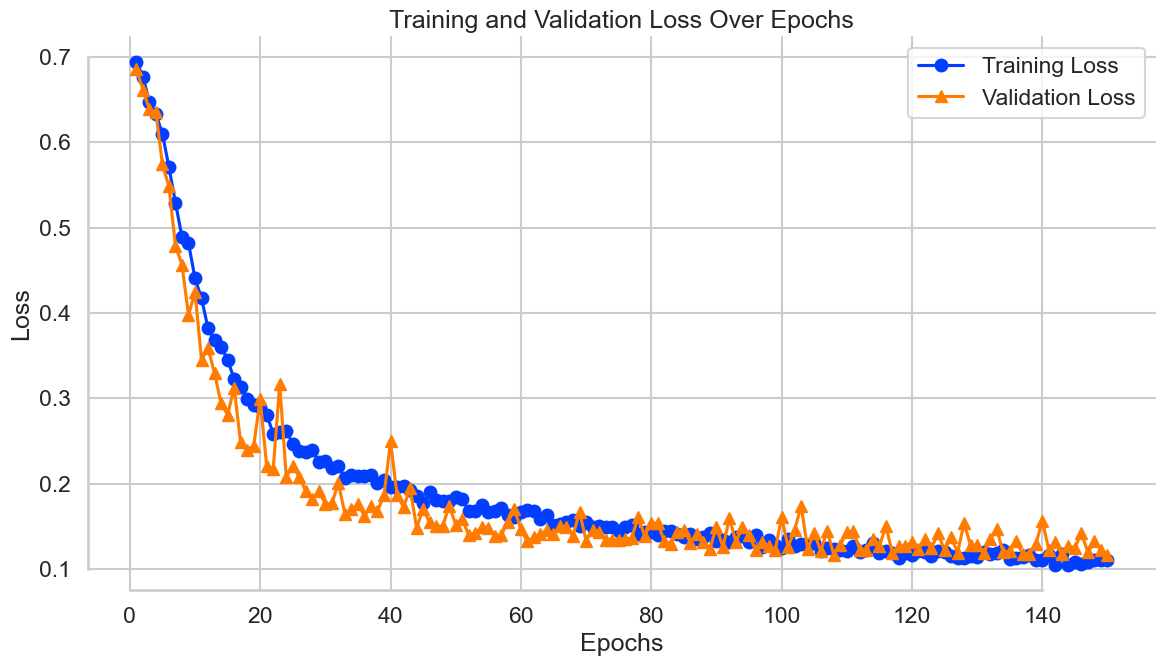

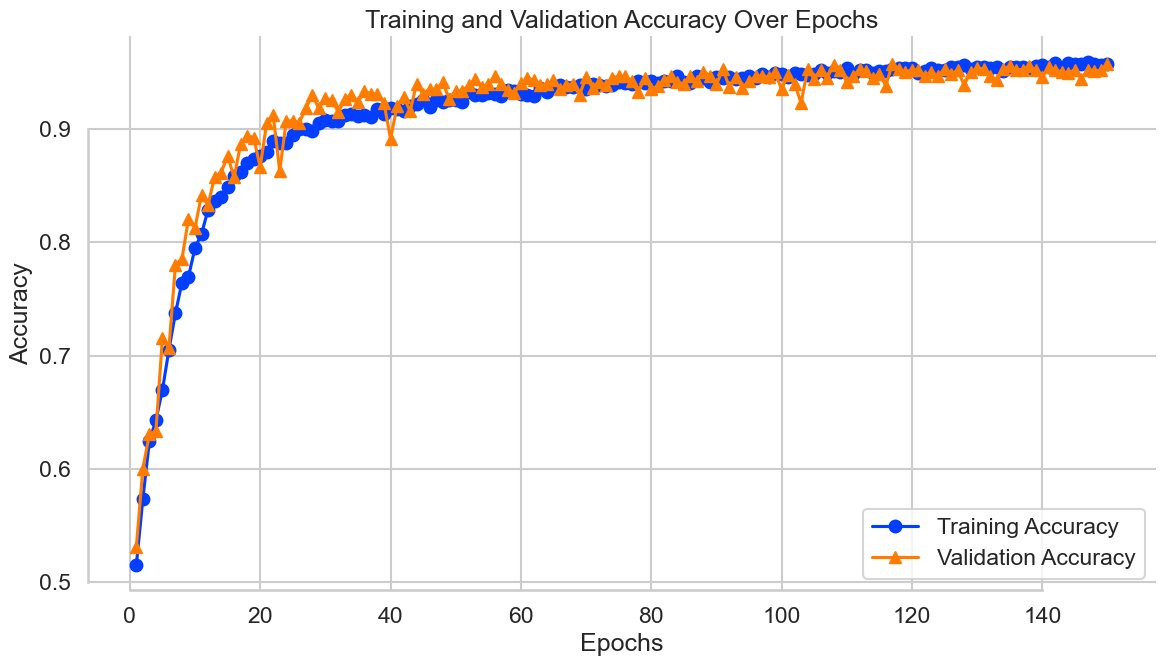

In [25]:
rangemin = 0
rangemax = 150

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    sns.set_context("talk")  
    sns.set_style("whitegrid")  
    sns.set_palette("bright")  

    epochs = range(1, len(train_losses) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(12, 7))
    plt.plot(epochs[rangemin:rangemax], train_losses[rangemin:rangemax], marker='o', label='Training Loss')
    plt.plot(epochs[rangemin:rangemax], val_losses[rangemin:rangemax], marker='^', label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    sns.despine(trim=True) 
    plt.show()

    # Plot training and validation accuracy
    plt.figure(figsize=(12, 7))
    plt.plot(epochs[rangemin:rangemax], train_accuracies[rangemin:rangemax], marker='o', label='Training Accuracy')
    plt.plot(epochs[rangemin:rangemax], val_accuracies[rangemin:rangemax], marker='^', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    sns.despine(trim=True)
    plt.show()

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)